In [136]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader

In [137]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        print(self.n_hidden_layers)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            # torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)

    model.apply(init_weights)

def fit(pinns_calss, training_set_boundary, training_set_collocation, num_epochs, optimizer, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, ((inp_train_b, u_train_b), (inp_train_c, u_train_c)) in enumerate(zip(training_set_boundary, training_set_collocation)):
            def closure():
                optimizer.zero_grad()
                loss = pinns_calss.compute_loss(inp_train_b, u_train_b, inp_train_c, u_train_c)
                loss.backward()
                running_loss[0] += loss.item()
                return loss
            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set_boundary)))
        history.append(running_loss[0])

    return history
    


In [156]:
class Pinn:
    def __init__(self):
        self.domain_extrema = torch.tensor([0, 1.0])

        self.approximate_solution = NeuralNet(input_dimension=1, output_dimension=1, n_hidden_layers=4, neurons=20)
        torch.manual_seed(12)
        init_xavier(self.approximate_solution)

        #eigenvalue
        n = 1
        self.lam = n*np.pi/(self.domain_extrema[1]-self.domain_extrema[0])


    # Function returning the training set S_sb corresponding to the spatial boundary
    def add_boundary_points(self):
        x0 = self.domain_extrema[0]
        xL = self.domain_extrema[1]
        bd_value = 0.0
        return torch.tensor([x0,xL]).reshape(-1,1),torch.tensor([bd_value,bd_value]).reshape(-1,1)

    # Function returning the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_collocation_points(self, n_collocation):
        self.soboleng = torch.quasirandom.SobolEngine(dimension=1)
        input_collocation = self.soboleng.draw(n_collocation)
        # torch.random.manual_seed(random_seed)
        # input_collocation = torch.rand([n_collocation, 2]).type(torch.FloatTensor)
        input_collocation = self.convert(input_collocation)

        output_collocation = torch.zeros((n_collocation, 1))
        return input_collocation.reshape(-1,1), output_collocation.reshape(-1,1)

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_boundary, output_boundary):
        pred_output_boundary = self.approximate_solution(input_boundary)
        assert (pred_output_boundary.shape[1] == output_boundary.shape[1])
        return output_boundary, pred_output_boundary

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_collocation):
        input_collocation.requires_grad = True
        u = self.approximate_solution(input_collocation).reshape(-1, )

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xm,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxm, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dL/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dL/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_collocation, create_graph=True)[0]
        grad_u_xx = torch.autograd.grad(grad_u.sum(), input_collocation, create_graph=True)[0]

        # torch.autograd.grad(grad_u_t.sum(), input_collocation, create_graph=True)[0][:, 1] = torch.autograd.grad(grad_u_x.sum(), input_collocation, create_graph=True)[0][:, 0]

        # u_tt = a**2 u_xx
        residual = grad_u_xx + u*self.lam**2
        
        return residual.reshape(-1, )

    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        return tens * (self.domain_extrema[1] - self.domain_extrema[0]) + self.domain_extrema[0]

    def compute_loss(self, inp_train_b, u_train_b, inp_train_c, u_train_c):
        u_train_b, u_pred_b = self.apply_boundary_conditions(inp_train_b, u_train_b)
        u_train_b = u_train_b.reshape(-1,1)
        u_pred_b = u_pred_b.reshape(-1,1)

        r_int = self.compute_pde_residual(inp_train_c)  # - u_train_c.reshape(-1,)
        r_sb = u_train_b - u_pred_b

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        u_pred_c = self.approximate_solution(inp_train_c)
        loss_1 = torch.abs(torch.norm(u_pred_c)-1.0)

        lambda_u = 10

        loss = torch.log10(lambda_u * (loss_sb) + loss_int) + (torch.norm(u_pred_b)-1.0)
        print("Total loss: ", round(loss.item(), 4), "| PDE Log Residual: ", round(torch.log10(loss_sb).item(), 4), "| Function Log Change: ", round(torch.log10(loss_int).item(), 4), "| 1 Log Constraint: ", round(torch.log10(loss_1).item(), 4))

        return loss

In [157]:
n_coll = 8192

pinn = Pinn()
# Generate S_sb, S_tb, S_int
input_b_, output_b_ = pinn.add_boundary_points()  # S_sb
input_c_, output_c_ = pinn.add_collocation_points(n_coll)  # S_int


4


In [158]:
training_set_b = DataLoader(torch.utils.data.TensorDataset(input_b_, output_b_), batch_size=2, shuffle=False)
training_set_c = DataLoader(torch.utils.data.TensorDataset(input_c_, output_c_), batch_size=n_coll, shuffle=False)

n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(), lr=float(0.5), max_iter=100, max_eval=5000, history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
hist = fit(pinn, training_set_b, training_set_c, num_epochs=n_epochs, optimizer=optimizer_LBFGS, verbose=True)


################################  0  ################################
Total loss:  3.7354 | PDE Log Residual:  0.461 | Function Log Change:  2.2681 | 1 Log Constraint:  2.2152
Total loss:  3.4533 | PDE Log Residual:  0.3883 | Function Log Change:  2.1765 | 1 Log Constraint:  2.1699
Total loss:  1.8733 | PDE Log Residual:  -0.1389 | Function Log Change:  1.5945 | 1 Log Constraint:  1.6542
Total loss:  1.2725 | PDE Log Residual:  -0.3938 | Function Log Change:  1.2924 | 1 Log Constraint:  1.5025
Total loss:  1.0209 | PDE Log Residual:  -0.6461 | Function Log Change:  1.3024 | 1 Log Constraint:  1.6497
Total loss:  -0.1084 | PDE Log Residual:  -1.2466 | Function Log Change:  0.4803 | 1 Log Constraint:  1.3759
Total loss:  2.0148 | PDE Log Residual:  -0.0557 | Function Log Change:  1.602 | 1 Log Constraint:  1.6906
Total loss:  -0.2069 | PDE Log Residual:  -1.5352 | Function Log Change:  0.5145 | 1 Log Constraint:  1.2399
Total loss:  -0.6387 | PDE Log Residual:  -2.2623 | Function Log Cha

(array([-2.7107075e-05], dtype=float32), array([9.564683e-06], dtype=float32))

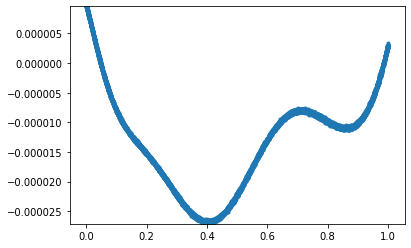

In [159]:
pred = pinn.approximate_solution(input_c_)
pred = pred.detach().numpy()
plt.scatter(input_c_,pred,marker = ".")
plt.ylim(min(pred),max(pred))